# Feature Importance Analysis for Credit Card Fraud Detection

This notebook analyzes which features are most useful for fraud detection. We take two approaches, firstly using a random forest classifier, and secondly by considering distribution separation.



## Feature selection using a random forest classifier
1. Load and preprocess the data
2. Calculate feature importance using Random Forest
3. Visualize the importance scores
4. Identify features that account for 95% of the total importance
5. Analyze correlations between important features
6. Show distributions of top features by class

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('../data/creditcard.csv')

# Separate features and target
feature_columns = ['V%d' % i for i in range(1,29)] + ['Amount', 'Time']
X = df[feature_columns]
y = df['Class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns)

# Train Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)


# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

# Show top features that account for 95% of importance
importance_threshold = 0.95
top_features = feature_importance[
    feature_importance['cumulative_importance'] <= importance_threshold
]

print(f"\nFeatures accounting for {importance_threshold*100}% of importance:")
print(top_features)





Features accounting for 95.0% of importance:
   feature  importance  cumulative_importance
16     V17    0.190009               0.190009
13     V14    0.130959               0.320968
11     V12    0.107772               0.428740
15     V16    0.073048               0.501788
9      V10    0.071184               0.572972
10     V11    0.062644               0.635616
3       V4    0.030328               0.665944
8       V9    0.029658               0.695603
6       V7    0.027435               0.723038
17     V18    0.023388               0.746426
2       V3    0.019903               0.766329
25     V26    0.019685               0.786014
0       V1    0.015370               0.801384
19     V20    0.015017               0.816401
5       V6    0.014986               0.831387
20     V21    0.013437               0.844824
1       V2    0.013320               0.858144
26     V27    0.012797               0.870941
29    Time    0.012634               0.883575
27     V28    0.011723            

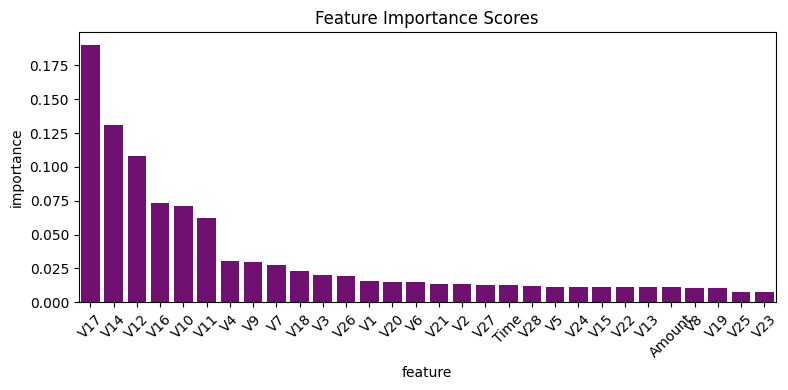

# Results discussion

## Random forest
### Top Features by Importance
The top 6 features account for about 63.5% of the total importance:
- V17 (19.0%)
- V14 (13.1%)
- V12 (10.8%)
- V16 (7.3%)
- 10 (7.1%)
- V11 (6.3%)



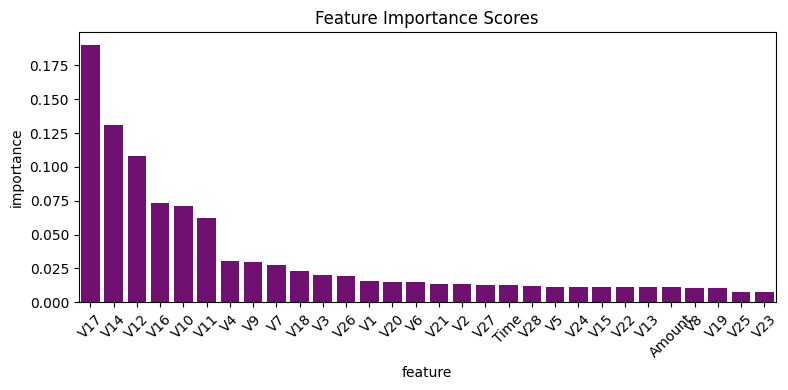

In [22]:
# Visualize feature importances
plt.figure(figsize=(8, 4))
sns.barplot(
    data=feature_importance, 
    x='feature', 
    y='importance',
    color= 'purple')
plt.xticks(rotation=45)
plt.title('Feature Importance Scores')
plt.tight_layout()
plt.show()

### Distribution analysis
The KDE plots for the top features show clear separation between fraudulent (orange) and legititmate (blue) transactions.

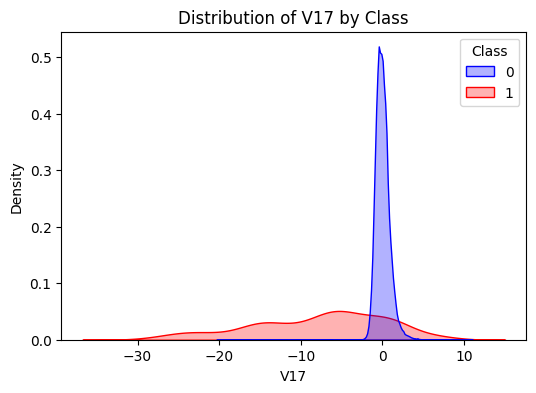

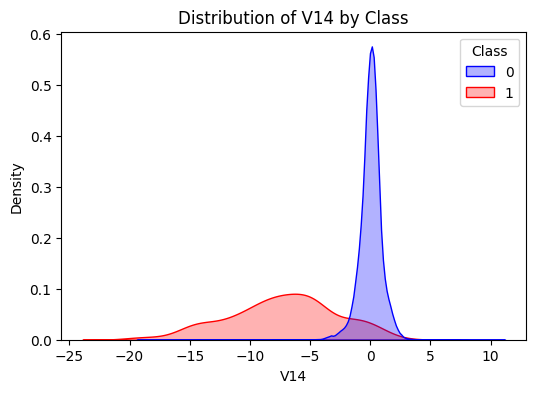

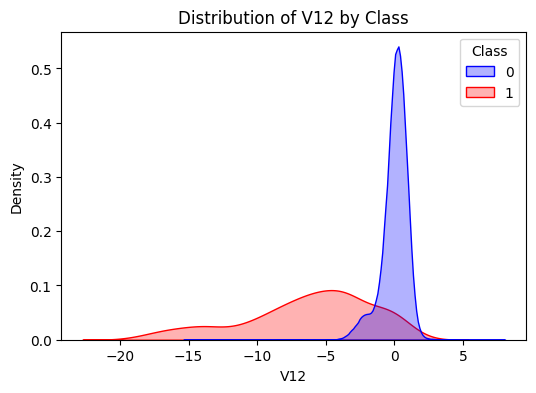

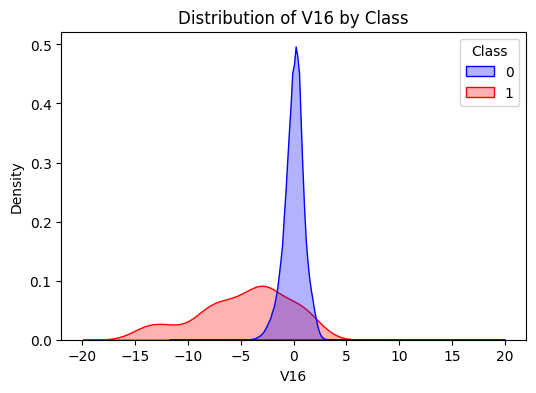

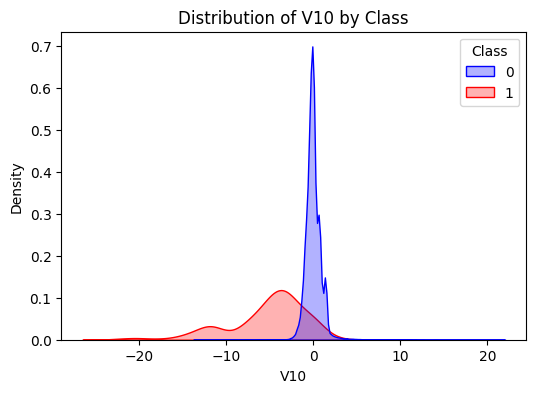

In [23]:
# Distribution Analysis of Top Features
for feature in top_feature_names[:5]:  # Show top 5 features
    plt.figure(figsize=(6, 4))
    sns.kdeplot(
        data=X_scaled, 
        x=feature, 
        hue=y, 
        common_norm=False,
        fill=True,
        alpha=0.3,
        palette=["blue", "red"])
    plt.title(f'Distribution of {feature} by Class')
    plt.show()

### Correlation analysis
The top features have low correlation with each other - this means they contribute unique information to the model.

The Time and Amount features are rated as having a relatively low importance, so they may not be as useful as the top features. We may consider excluding them from model training.



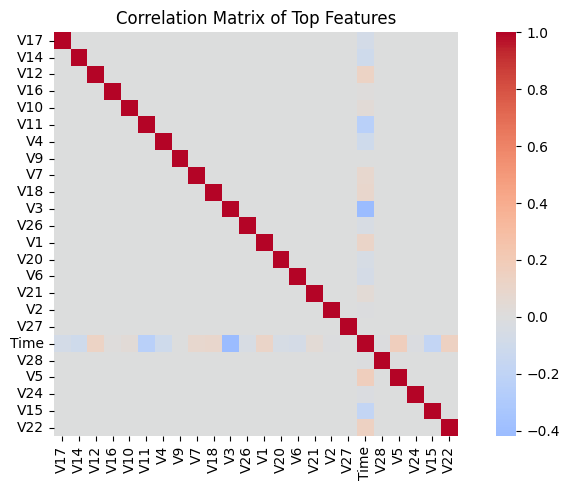

In [24]:
# Additional Analysis: Correlation between important features
top_feature_names = top_features['feature'].tolist()
correlation_matrix = X_scaled[top_feature_names].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.show()

## Distribution separation

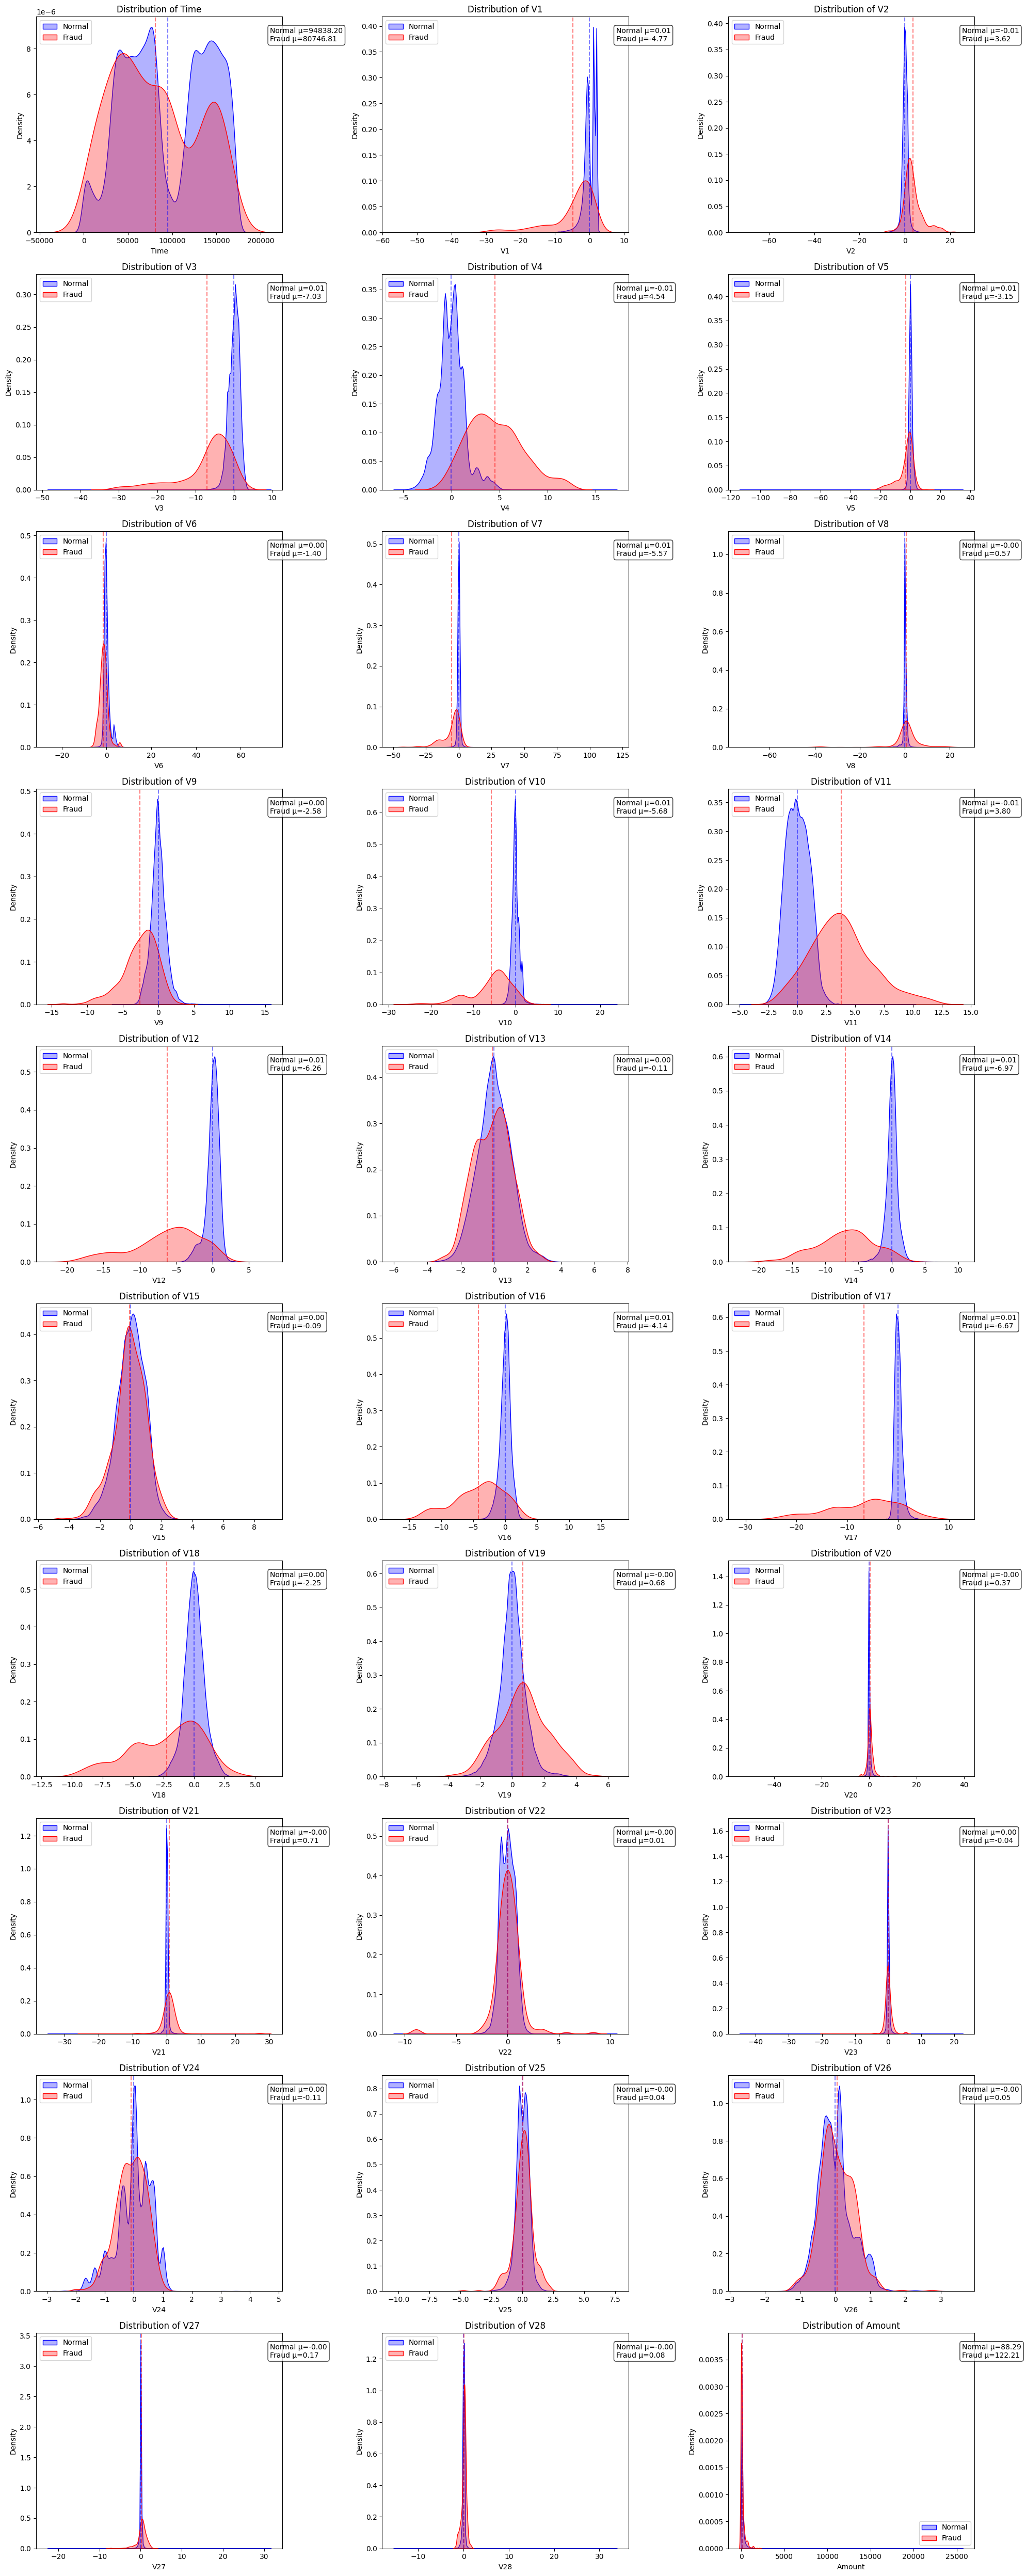


Feature Separation Analysis (sorted by mean difference):
--------------------------------------------------------------------------------
Feature     Mean Diff    Overlap    Fraud μ   Normal μ
--------------------------------------------------------------------------------
Time         14091.40       0.64   80746.81   94838.20
Amount          33.92       0.93     122.21      88.29
V3               7.05       0.30      -7.03       0.01
V14              6.98       0.16      -6.97       0.01
V17              6.68       0.20      -6.67       0.01
V12              6.27       0.22      -6.26       0.01
V10              5.69       0.20      -5.68       0.01
V7               5.58       0.37      -5.57       0.01
V1               4.78       0.51      -4.77       0.01
V4               4.55       0.24       4.54      -0.01
V16              4.15       0.30      -4.14       0.01
V11              3.81       0.25       3.80      -0.01
V2               3.63       0.37       3.62      -0.01
V5        

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_separated_distributions(df, n_cols=3, figsize=(20, 5)):
    """
    Create separate distribution plots for fraudulent and non-fraudulent transactions
    for each feature.

    Args:
        df: pandas DataFrame with transaction data
        n_cols: number of columns in the subplot grid
        figsize: base figure size (will be multiplied by number of rows needed)
    """
    # Get feature names (excluding 'Class')
    features = [col for col in df.columns if col != 'Class']

    # Calculate number of rows needed
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols

    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(figsize[0], figsize[1] * n_rows))
    axes = axes.ravel()

    # Split data by class
    fraud_data = df[df['Class'] == 1]
    normal_data = df[df['Class'] == 0]

    for idx, feature in enumerate(features):
        # Create two separate distributions on the same subplot
        sns.kdeplot(data=normal_data[feature],
                   ax=axes[idx],
                   color='blue',
                   label='Normal',
                   fill=True,
                   alpha=0.3)

        sns.kdeplot(data=fraud_data[feature],
                   ax=axes[idx],
                   color='red',
                   label='Fraud',
                   fill=True,
                   alpha=0.3)

        # Add feature statistics
        normal_mean = normal_data[feature].mean()
        fraud_mean = fraud_data[feature].mean()

        # Add vertical lines for means
        axes[idx].axvline(normal_mean, color='blue', linestyle='--', alpha=0.5)
        axes[idx].axvline(fraud_mean, color='red', linestyle='--', alpha=0.5)

        # Add title and labels
        axes[idx].set_title(f'Distribution of {feature}')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Density')

        # Add legend
        axes[idx].legend()

        # Add text with basic statistics
        stats_text = f'Normal μ={normal_mean:.2f}\nFraud μ={fraud_mean:.2f}'
        axes[idx].text(0.95, 0.95, stats_text,
                      transform=axes[idx].transAxes,
                      verticalalignment='top',
                      horizontalalignment='left',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Remove empty subplots
    for idx in range(len(features), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

def print_feature_separation_metrics(df):
    """
    Print metrics about how well each feature separates the classes

    Args:
        df: pandas DataFrame with transaction data
    """
    features = [col for col in df.columns if col != 'Class']

    # Calculate separation metrics for each feature
    separation_metrics = {}

    for feature in features:
        fraud_data = df[df['Class'] == 1][feature]
        normal_data = df[df['Class'] == 0][feature]

        # Calculate basic statistics
        metrics = {
            'fraud_mean': fraud_data.mean(),
            'normal_mean': normal_data.mean(),
            'mean_diff': abs(fraud_data.mean() - normal_data.mean()),
            'fraud_std': fraud_data.std(),
            'normal_std': normal_data.std(),
            'overlap_coeff': calculate_overlap(fraud_data, normal_data)
        }

        separation_metrics[feature] = metrics

    # Print results sorted by mean difference
    print("\nFeature Separation Analysis (sorted by mean difference):")
    print("-" * 80)
    print(f"{'Feature':<10} {'Mean Diff':>10} {'Overlap':>10} {'Fraud μ':>10} {'Normal μ':>10}")
    print("-" * 80)

    sorted_features = sorted(separation_metrics.items(),
                           key=lambda x: x[1]['mean_diff'],
                           reverse=True)

    for feature, metrics in sorted_features:
        print(f"{feature:<10} {metrics['mean_diff']:>10.2f} {metrics['overlap_coeff']:>10.2f} "
              f"{metrics['fraud_mean']:>10.2f} {metrics['normal_mean']:>10.2f}")

def calculate_overlap(dist1, dist2, bins=100):
    """Calculate approximate distribution overlap coefficient"""
    # Get the range for both distributions
    min_val = min(dist1.min(), dist2.min())
    max_val = max(dist1.max(), dist2.max())

    # Calculate histograms
    hist1, bins = np.histogram(dist1, bins=bins, range=(min_val, max_val), density=True)
    hist2, _ = np.histogram(dist2, bins=bins, range=(min_val, max_val), density=True)

    # Calculate overlap coefficient
    overlap = np.minimum(hist1, hist2).sum() * (bins[1] - bins[0])

    return overlap

# Example usage:
# df = pd.read_csv('creditcard.csv')
# plot_separated_distributions(df)
# print_feature_separation_metrics(df)


# Load the data
#df = pd.read_csv('/content/drive/MyDrive/Studies/Final Project/Code/creditcard.csv')
df = pd.read_csv('../data/creditcard.csv')

plot_separated_distributions(df)

print_feature_separation_metrics(df)

## Distribtuion separation results

Distribution Separation Top 6 (excluding Time/Amount):
- V3 (overlap: 0.30)
- V14 (overlap: 0.16)
- V17 (overlap: 0.20)
- V12 (overlap: 0.22)
- V10 (overlap: 0.20)
- V7 (overlap: 0.37)

There's significant overlap between these rankings, with V14, V17, V12, and V10 appearing in both top lists. This cross-validation between two different methods strengthens our feature selection confidence.

## Recommended features
Based on both analyses, the following features will be selected for model training.

primary_features = ['V14', 'V17', 'V12', 'V10', 'V3', 'V7', 'V4', 'V16', 'V11']

These features appear important in both analyses, and they have low overlap coefficients.

## Notes

Feature selection is the process of reducing the dimentionality of a dataset by removing features that are less useful or redundant for model training. Effective feature selection can improve learning accuracy, reduce learning time, and simplyfy learning results (Cai et al 2018, Benkessirat and Benblidia, 2019). A smaller feature set also decreases computational cost, and by focusing on a smaller set of features, the model's decision-making process becomes easier to understand and explain, which is an important aspect of financial applications of ML. (ML Journey 2024)

One of the approaches to feature selection is using statistical methods such as calculating distribution overlap - this is called a filter approach (Cai et al 2018). Typically with these methods, practitioners select features with high variance or features that have marked differences between fraudulent and legitimate transactions. In our analysis we generated KDE plots for features to see to what extent the distributions of the fraudulent and ligitimate class features overlapped. Features with little overlap are generally more useful for training the classification model. 

Another approach is using tree-based models, like random forest - this is an example of embedded methods (Cai et al 2018, ML Journey 2024). Tree-based models come with the handy feature of performing implicit feature selection. Random forest models calculate a feature importance score for each feature during training. The feature importance score tells us which features have the highest impact on the target. (geeksforgeeks, 2024)


#### Sources
https://mljourney.com/feature-selection-in-machine-learning-a-comprehensive-guide/
https://www.geeksforgeeks.org/feature-selection-techniques-in-machine-learning/
https://www.sciencedirect.com/science/article/pii/S0925231218302911
https://www.proquest.com/docview/2035943717/abstract/120D02201AFC4ED3PQ/1
https://ieeexplore.ieee.org/document/9035281/
